In [24]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import sys
sys.path.append("../")

In [375]:
import torch
from torch import nn

from inference.models.layers import SphericalGraphCNN

In [376]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [377]:
sys.path.append("../../fermi-gce-gp/")
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [378]:
ps_mask = np.load("../../fermi-gce-gp/data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

/Users/smsharma/anaconda3/lib/python3.7/site-packages/healpy-1.12.9-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/smsharma/anaconda3/lib/python3.7/site-packages/healpy-1.12.9-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


torch.Size([1, 16384, 1])

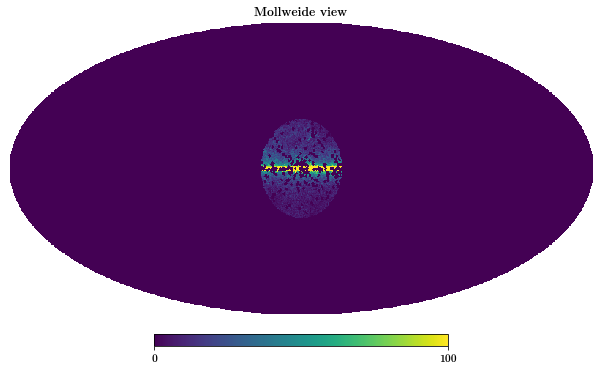

In [379]:
in_map = np.load("../../fermi-gce-gp/data/fermi_data/fermidata_counts.npy")
in_map[hp_mask] = 0

hp.mollview(in_map, max=100)

in_map = torch.Tensor(in_map[~masks_list[0]])
in_map = in_map.reshape((1, -1, 1))
in_map.shape

In [380]:
sg = SphericalGraphCNN(nside_list, indexes_list)

In [381]:
in_map.shape

torch.Size([1, 16384, 1])

In [383]:
sg(in_map).shape

torch.Size([1, 256])

In [366]:
from sbi import utils
from sbi import inference
from sbi.inference.base import infer

In [367]:
in_map.shape

torch.Size([1, 16384, 1])

In [368]:
def simulator_model(parameter, return_points=False):

    return in_map.reshape((1, -1))

In [370]:
# set prior distribution for the parameters 
prior = utils.BoxUniform(low=torch.tensor([0.0, -1.99]), 
                             high=torch.tensor([700.0, -0.2]))                           

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = inference.prepare_for_sbi(simulator_model, prior)

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='maf', 
                                      embedding_net=sg,
                                      hidden_features=10,
                                      num_transforms=4)

# setup the inference procedure with the SNPE-C procedure
inference_inst = inference.SNPE(simulator_wrapper, prior, 
                           density_estimator=neural_posterior, 
                           show_progress_bars=True)

# run the inference procedure on one round and 10000 simulated data points
posterior = inference_inst(num_simulations=1000)